<a href="https://colab.research.google.com/github/PRaliphada/ExpectedLoss/blob/main/Pfarelo_Yahoo_Finance_Data_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import yfinance as yf
import pandas as pd
import seaborn as sns

def get_yahoo_finance_data(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    data = stock.history(start=start_date, end=end_date)
    data['Ticker'] = ticker
    return data

tickers = ["AAPL", "MSFT", "GOOGL"]
start_date = "2022-08-15"
end_date = "2024-08-15"

financial_data = pd.DataFrame()
for ticker in tickers:
    data = get_yahoo_finance_data(ticker, start_date, end_date)
    data['Text'] = "Closing price for " + ticker + " on " + data.index.strftime('%Y-%m-%d') + " was " + data['Close'].astype(str)
    financial_data = pd.concat([financial_data, data])

pd.set_option('display.max_rows', None)

print(financial_data)

                                 Open        High         Low       Close  \
Date                                                                        
2022-08-15 00:00:00-04:00  169.640417  171.489920  169.472281  171.292114   
2022-08-16 00:00:00-04:00  170.886605  171.806421  169.778883  171.133865   
2022-08-17 00:00:00-04:00  170.876714  174.219664  170.678909  172.637207   
2022-08-18 00:00:00-04:00  171.845997  172.983389  171.222896  172.241608   
2022-08-19 00:00:00-04:00  171.133859  171.836085  169.432706  169.640411   
2022-08-22 00:00:00-04:00  167.830436  167.998571  165.308377  165.733673   
2022-08-23 00:00:00-04:00  165.249065  166.861208  164.823769  165.397415   
2022-08-24 00:00:00-04:00  165.486447  166.267784  164.428166  165.694138   
2022-08-25 00:00:00-04:00  166.930446  168.275543  166.505165  168.166748   
2022-08-26 00:00:00-04:00  168.700816  169.175552  161.767625  161.826965   
2022-08-29 00:00:00-04:00  159.384036  161.114859  158.068624  159.611526   

In [12]:
descriptive_stats = financial_data.groupby('Ticker')['Close'].describe()
print("Descriptive Statistics:\n", descriptive_stats)

Descriptive Statistics:
         count        mean        std         min         25%         50%  \
Ticker                                                                     
AAPL    503.0  172.940901  22.939588  123.855095  153.699112  173.323090   
GOOGL   503.0  127.699942  27.196848   83.334358  102.787033  128.932022   
MSFT    503.0  330.555878  70.650845  210.619064  259.626373  328.047882   

               75%         max  
Ticker                          
AAPL    188.373283  234.548523  
GOOGL   142.436523  191.179993  
MSFT    401.271637  466.718781  


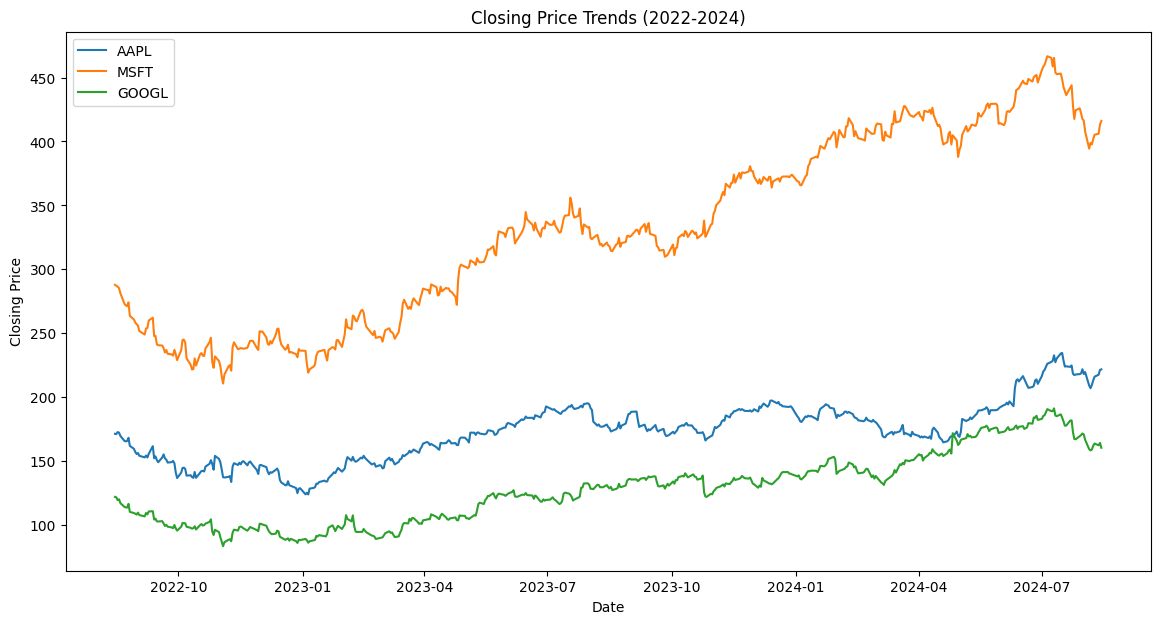

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(financial_data[financial_data['Ticker'] == ticker].index,
             financial_data[financial_data['Ticker'] == ticker]['Close'],
             label=ticker)

plt.title('Closing Price Trends (2022-2024)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [14]:
pivot_data = financial_data.pivot_table(values='Close', index=financial_data.index, columns='Ticker')

correlation_matrix = pivot_data.corr()
print("Correlation Matrix:\n", correlation_matrix)


Correlation Matrix:
 Ticker      AAPL     GOOGL      MSFT
Ticker                              
AAPL    1.000000  0.858651  0.855548
GOOGL   0.858651  1.000000  0.948132
MSFT    0.855548  0.948132  1.000000


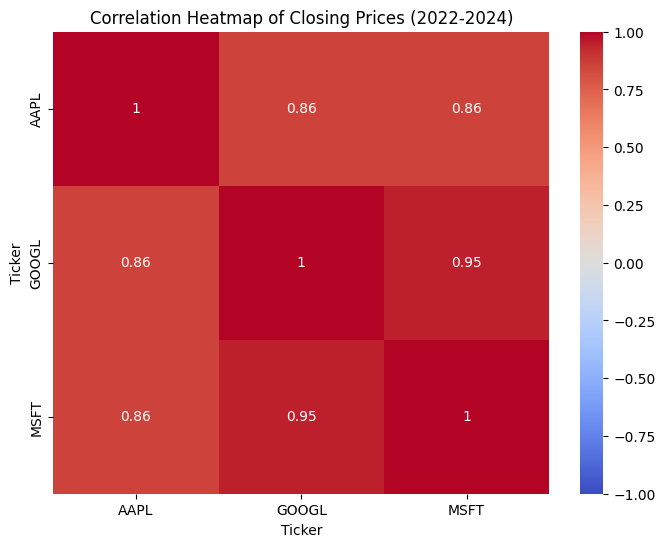

In [17]:
correlation_matrix = pivot_data.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Closing Prices (2022-2024)')
plt.show()

In [21]:
import yfinance as yf
import numpy as np
from scipy.stats import norm
from scipy.optimize import fsolve

# Function to calculate d1 and d2
def calculate_d1_d2(V, D, r, sigma_V, T):
    d1 = (np.log(V / D) + (r + 0.5 * sigma_V**2) * T) / (sigma_V * np.sqrt(T))
    d2 = d1 - sigma_V * np.sqrt(T)
    return d1, d2

# Function to solve for asset value (V) and volatility (sigma_V)
def merton_model_solver(E, D, r, sigma_E, T):
    def equations(vars):
        V, sigma_V = vars
        d1, d2 = calculate_d1_d2(V, D, r, sigma_V, T)
        eq1 = E - (V * norm.cdf(d1) - D * np.exp(-r * T) * norm.cdf(d2))
        eq2 = sigma_E - (norm.cdf(d1) * sigma_V * V / E)
        return [eq1, eq2]

    V0 = E + D  # Initial guess for V
    sigma_V0 = sigma_E  # Initial guess for sigma_V
    V, sigma_V = fsolve(equations, [V0, sigma_V0])
    return V, sigma_V

# Function to calculate the Probability of Default (PD) using the Merton model
def calculate_pd(ticker, start_date, end_date, debt, risk_free_rate=0.03):
    # Fetch stock data
    stock = yf.Ticker(ticker)
    stock_data = stock.history(start=start_date, end=end_date)

    # Calculate market value of equity (latest close price * shares outstanding)
    E = stock_data['Close'].iloc[-1] * stock.info['sharesOutstanding']

    # Calculate annualized equity volatility (using daily returns)
    stock_data['Returns'] = stock_data['Close'].pct_change()
    sigma_E = stock_data['Returns'].std() * np.sqrt(252)  # Annualize the volatility

    # Assume a 1-year time horizon (T)
    T = 1

    # Estimate asset value (V) and volatility (sigma_V) using Merton model solver
    V, sigma_V = merton_model_solver(E, debt, risk_free_rate, sigma_E, T)

    # Calculate d1 and d2
    d1, d2 = calculate_d1_d2(V, debt, risk_free_rate, sigma_V, T)

    # Calculate Probability of Default (PD)
    PD = norm.cdf(-d2)
    return PD

# Example usage: Calculate PD for Apple (AAPL)
ticker = "GOOGL"
start_date = "2023-08-15"
end_date = "2024-08-15"
debt = 1.5e11  # Example debt value (this should ideally come from financial statements)
pd = calculate_pd(ticker, start_date, end_date, debt)
print(f"Probability of Default for {ticker}: {pd:.4%}")


Probability of Default for GOOGL: 0.0000%


In [22]:
# Example with updated debt value
debt_updated = 2e11  # Example higher debt value
pd_updated = calculate_pd(ticker, start_date, end_date, debt_updated)
print(f"Updated Probability of Default for {ticker}: {pd_updated:.4%}")


Updated Probability of Default for GOOGL: 0.0000%


In [23]:
import yfinance as yf
import numpy as np

def get_bond_yield(ticker):
    bond = yf.Ticker(ticker)
    bond_data = bond.history(period='1y')
    # Assume the yield is available in bond_data or from an external source
    # For this example, we use a placeholder yield
    return bond_data['Close'].mean()  # Replace with actual yield extraction

def calculate_credit_spread(corporate_yield, risk_free_yield):
    return corporate_yield - risk_free_yield

def estimate_default_probability(credit_spread):
    # This is a simplified assumption; actual calculation requires calibration
    # Default Probability (PD) = 1 - exp(-Credit Spread / Risk-Free Rate)
    # Note: This is a simplified model for illustrative purposes
    pd = 1 - np.exp(-credit_spread / 100)
    return pd

# Example tickers for corporate and government bonds
corporate_bond_ticker = 'AAPL'
government_bond_ticker = '^TNX'

# Obtain yields
corporate_yield = get_bond_yield(corporate_bond_ticker)
government_yield = get_bond_yield(government_bond_ticker)

# Calculate credit spread
credit_spread = calculate_credit_spread(corporate_yield, government_yield)

# Estimate default probability
default_probability = estimate_default_probability(credit_spread)
print(f"Estimated Default Probability: {default_probability:.4%}")


Estimated Default Probability: 84.0480%


In [24]:
import numpy as np

# Function to calculate the credit spread between corporate and risk-free yields
def calculate_credit_spread(corporate_yield, risk_free_yield):
    return corporate_yield - risk_free_yield

# Function to estimate default probability based on credit spread
def estimate_default_probability(credit_spread):
    # Simplified assumption: Default Probability (PD) = 1 - exp(-Credit Spread / 100)
    # Note: This is a simplified model for illustrative purposes
    pd = 1 - np.exp(-credit_spread / 100)
    return pd

# Example placeholder yields (in percentage)
corporate_yield = 5.0  # Example yield for corporate bond
government_yield = 2.0  # Example yield for government bond

# Calculate credit spread
credit_spread = calculate_credit_spread(corporate_yield, government_yield)

# Estimate default probability
default_probability = estimate_default_probability(credit_spread)

print(f"Corporate Bond Yield: {corporate_yield}%")
print(f"Government Bond Yield: {government_yield}%")
print(f"Credit Spread: {credit_spread}%")
print(f"Estimated Default Probability: {default_probability:.4%}")


Corporate Bond Yield: 5.0%
Government Bond Yield: 2.0%
Credit Spread: 3.0%
Estimated Default Probability: 2.9554%


In [43]:
import requests
from bs4 import BeautifulSoup

def get_company_profile(ticker):
    url = f'https://finance.yahoo.com/quote/{ticker}/profile?p={ticker}'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    profile_section = soup.find('section', {'class': 'Mb(20px)'})
    if profile_section:
        profile_text = profile_section.get_text()
    else:
        profile_text = "Profile not found"

    return profile_text

ticker = 'AAPL'
profile_text = get_company_profile(ticker)
print(profile_text)


Profile not found


In [38]:
import requests
from bs4 import BeautifulSoup

def get_latest_news(ticker):
    url = f'https://finance.yahoo.com/quote/{ticker}?p={ticker}&.tsrc=fin-srch'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    news_articles = []
    for item in soup.find_all('li', {'class': 'js-stream-content'}):
        headline = item.find('h3').get_text()
        summary = item.find('p').get_text() if item.find('p') else "No summary available"
        news_articles.append((headline, summary))

    return news_articles

ticker = 'AAPL'
news_articles = get_latest_news(ticker)
for headline, summary in news_articles:
    print(f"Headline: {headline}")
    print(f"Summary: {summary}")
    print()


In [34]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.8 MB/s eta 0:00:00


In [44]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    sentiment_score = analyzer.polarity_scores(text)
    return sentiment_score

# Example usage
for headline, summary in news_articles:
    sentiment = analyze_sentiment(summary)
    print(f"Headline: {headline}")
    print(f"Summary: {summary}")
    print(f"Sentiment Score: {sentiment}")
    print()


In [39]:
import requests
from bs4 import BeautifulSoup

def get_company_profile(ticker):
    url = f'https://finance.yahoo.com/quote/{ticker}/profile?p={ticker}'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    try:
        # Look for the section containing the company profile
        profile_section = soup.find('section', {'class': 'quote-sub-section Mt(30px)'})
        if profile_section:
            profile_text = profile_section.get_text(separator='\n').strip()
        else:
            profile_text = "Profile not found or unable to extract."
    except Exception as e:
        profile_text = f"An error occurred: {str(e)}"

    return profile_text

ticker = 'AAPL'
profile_text = get_company_profile(ticker)
print(profile_text)


Profile not found or unable to extract.


In [40]:
import requests
from bs4 import BeautifulSoup

def get_latest_news(ticker):
    url = f'https://finance.yahoo.com/quote/{ticker}?p={ticker}&.tsrc=fin-srch'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    news_articles = []
    try:
        for item in soup.find_all('li', {'class': 'js-stream-content Pos(r)'}):
            headline = item.find('h3').get_text() if item.find('h3') else "No headline available"
            summary = item.find('p').get_text() if item.find('p') else "No summary available"
            news_articles.append((headline, summary))
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return []

    return news_articles

ticker = 'AAPL'
news_articles = get_latest_news(ticker)
if news_articles:
    for headline, summary in news_articles:
        print(f"Headline: {headline}")
        print(f"Summary: {summary}")
        print()
else:
    print("No news articles found or unable to extract.")


No news articles found or unable to extract.


In [45]:
import pandas as pd

# Load the data
df = pd.read_csv('german_credit_data.csv')

# Display the first few rows to understand the structure
print(df.head())


   Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
0           0   67    male    2     own             NaN           little   
1           1   22  female    2     own          little         moderate   
2           2   49    male    1     own          little              NaN   
3           3   45    male    2    free          little           little   
4           4   53    male    2    free          little           little   

   Credit amount  Duration              Purpose  
0           1169         6             radio/TV  
1           5951        48             radio/TV  
2           2096        12            education  
3           7882        42  furniture/equipment  
4           4870        24                  car  


In [46]:
# Check for missing values
print(df.isnull().sum())

# Check data types
print(df.dtypes)

# If needed, convert categorical variables to the appropriate type
df['Sex'] = df['Sex'].astype('category')
df['Housing'] = df['Housing'].astype('category')
df['Saving accounts'] = df['Saving accounts'].astype('category')
df['Purpose'] = df['Purpose'].astype('category')


Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64
Unnamed: 0           int64
Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
dtype: object


In [47]:
# Summary statistics for numeric columns
print(df.describe())

# Distribution of categorical variables
print(df['Sex'].value_counts())
print(df['Job'].value_counts())
print(df['Housing'].value_counts())
print(df['Saving accounts'].value_counts())
print(df['Purpose'].value_counts())


        Unnamed: 0          Age          Job  Credit amount     Duration
count  1000.000000  1000.000000  1000.000000    1000.000000  1000.000000
mean    499.500000    35.546000     1.904000    3271.258000    20.903000
std     288.819436    11.375469     0.653614    2822.736876    12.058814
min       0.000000    19.000000     0.000000     250.000000     4.000000
25%     249.750000    27.000000     2.000000    1365.500000    12.000000
50%     499.500000    33.000000     2.000000    2319.500000    18.000000
75%     749.250000    42.000000     2.000000    3972.250000    24.000000
max     999.000000    75.000000     3.000000   18424.000000    72.000000
Sex
male      690
female    310
Name: count, dtype: int64
Job
2    630
1    200
3    148
0     22
Name: count, dtype: int64
Housing
own     713
rent    179
free    108
Name: count, dtype: int64
Saving accounts
little        603
moderate      103
quite rich     63
rich           48
Name: count, dtype: int64
Purpose
car                    337


In [50]:
from sklearn.preprocessing import LabelEncoder

# Label Encoding for categorical variables
label_encoders = {}
for column in df.select_dtypes(include=['category', 'object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Now you can calculate the correlation matrix
corr_matrix = df.corr()
print(corr_matrix)



                  Unnamed: 0       Age       Sex       Job   Housing  \
Unnamed: 0          1.000000 -0.010096 -0.001693 -0.027345  0.025452   
Age                -0.010096  1.000000  0.161694  0.015673 -0.301419   
Sex                -0.001693  0.161694  1.000000  0.070298 -0.219844   
Job                -0.027345  0.015673  0.070298  1.000000 -0.107191   
Housing             0.025452 -0.301419 -0.219844 -0.107191  1.000000   
Saving accounts     0.003730  0.084245  0.034982  0.011709 -0.006505   
Checking account    0.005852  0.059751  0.025578  0.040663 -0.022424   
Credit amount       0.013488  0.032716  0.093482  0.285385 -0.135632   
Duration            0.030788 -0.036136  0.081432  0.210910 -0.157049   
Purpose            -0.036897 -0.074084 -0.063231 -0.025326  0.020633   

                  Saving accounts  Checking account  Credit amount  Duration  \
Unnamed: 0               0.003730          0.005852       0.013488  0.030788   
Age                      0.084245          0.05

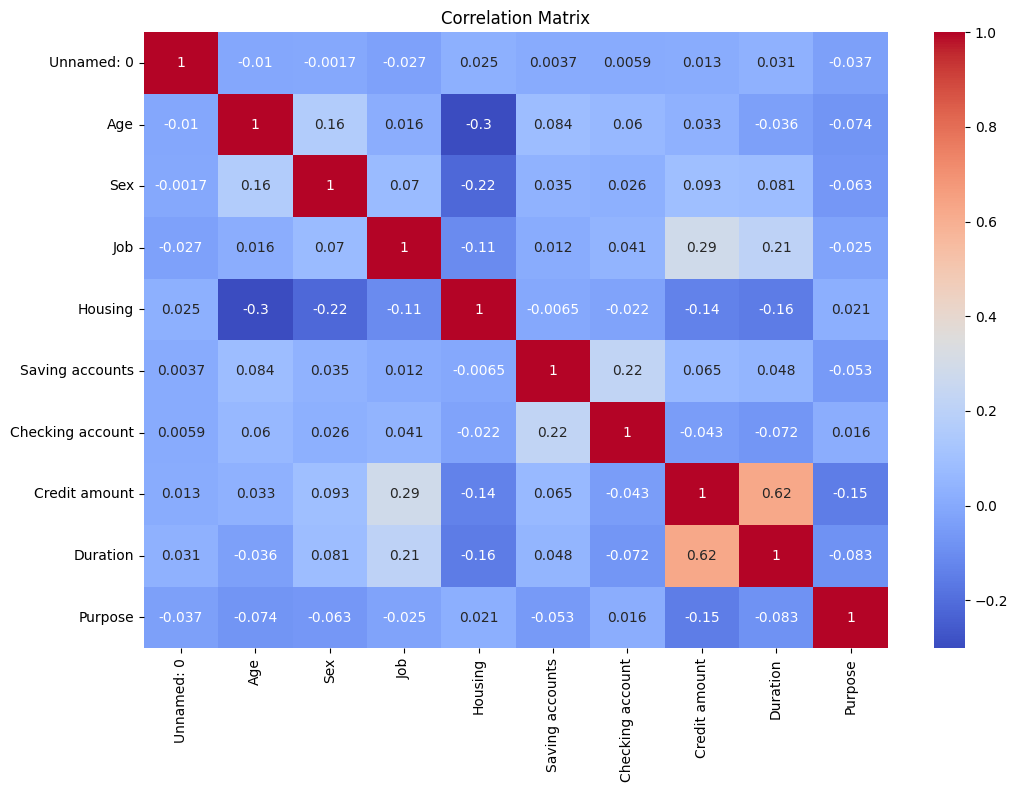

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size before plotting
plt.figure(figsize=(12, 8))  # Width=12, Height=8 (you can adjust these numbers)

# Plotting the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


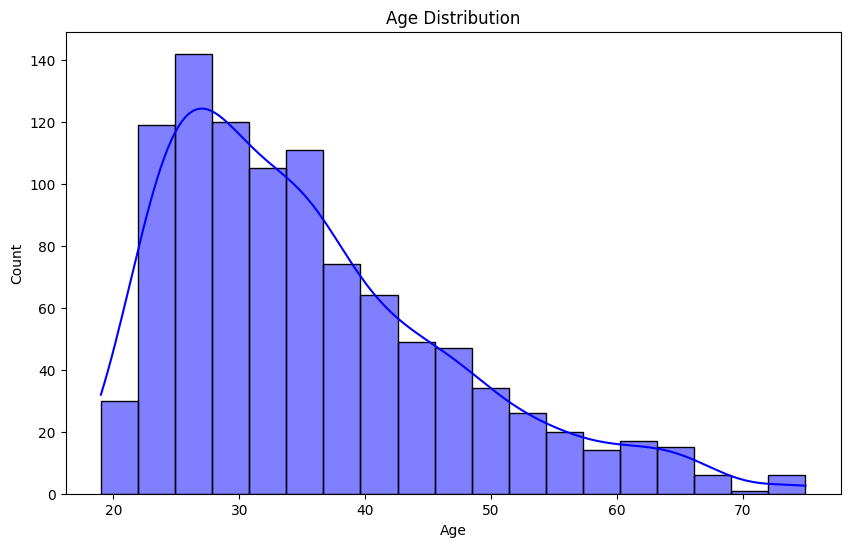

<ipython-input-58-cb93c70ac8b4>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Job', y='Credit amount', data=df, palette='pastel')  # Using Seaborn's pastel palette


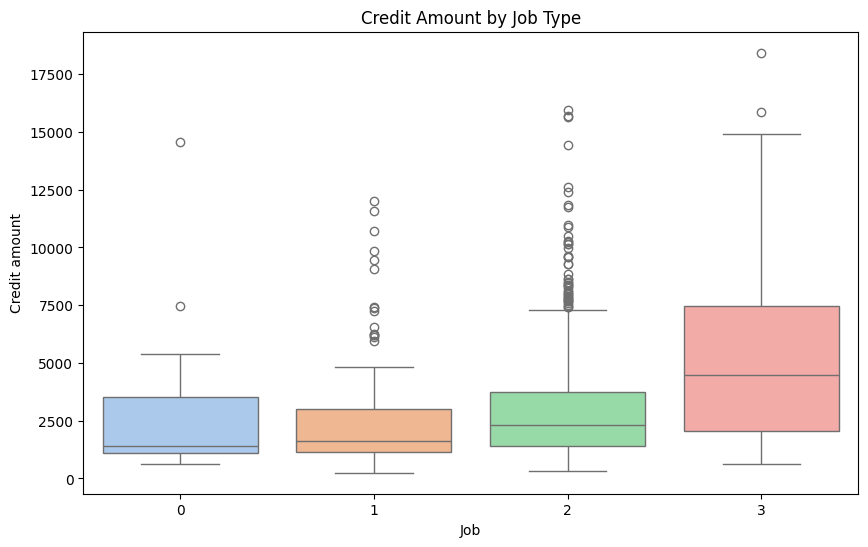

<ipython-input-58-cb93c70ac8b4>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Purpose', y='Credit amount', data=df, estimator=sum, palette='muted')  # Using Seaborn's muted palette


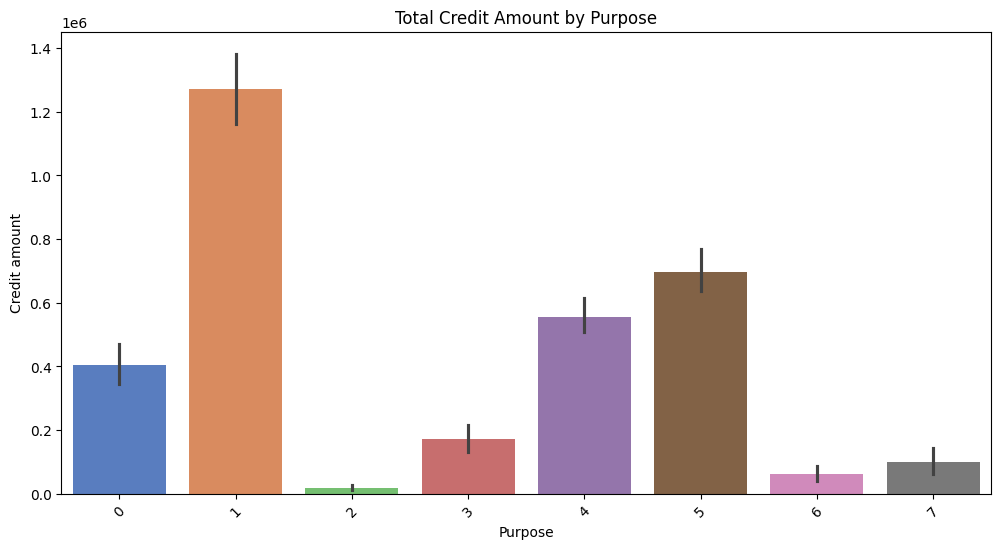

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a Seaborn color palette globally (optional)
sns.set_palette('deep')

# Histogram with Seaborn colors
plt.figure(figsize=(10, 6))  # Adjust the figure size
sns.histplot(df['Age'], kde=True, color='blue')  # You can specify individual colors or use palette defaults
plt.title('Age Distribution')
plt.show()

# Box Plot of Credit Amount by Job with Seaborn colors
plt.figure(figsize=(10, 6))  # Adjust the figure size
sns.boxplot(x='Job', y='Credit amount', data=df, palette='pastel')  # Using Seaborn's pastel palette
plt.title('Credit Amount by Job Type')
plt.show()

# Bar Plot of Purpose vs. Credit Amount with Seaborn colors
plt.figure(figsize=(12, 6))  # Adjust the figure size
sns.barplot(x='Purpose', y='Credit amount', data=df, estimator=sum, palette='muted')  # Using Seaborn's muted palette
plt.title('Total Credit Amount by Purpose')
plt.xticks(rotation=45)
plt.show()



In [60]:
!pip install transformers vaderSentiment


In [ ]:
import pandas as pd
import numpy as np
import re
from transformers import BertTokenizer, BertModel
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import torch


In [61]:

df = pd.read_csv('german_credit_data.csv')
# Preview the data
print(df.head())


   Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
0           0   67    male    2     own             NaN           little   
1           1   22  female    2     own          little         moderate   
2           2   49    male    1     own          little              NaN   
3           3   45    male    2    free          little           little   
4           4   53    male    2    free          little           little   

   Credit amount  Duration              Purpose  
0           1169         6             radio/TV  
1           5951        48             radio/TV  
2           2096        12            education  
3           7882        42  furniture/equipment  
4           4870        24                  car  


In [63]:
# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment['compound']

# Apply VADER sentiment analysis
df['VADER_Sentiment'] = df['df'].apply(vader_sentiment)


KeyError: 'df'

In [4]:
import pandas as pd
import re

# Example DataFrame
data = pd.read_csv('german_credit_data.csv')

df = pd.DataFrame(data)

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and digits
    text = text.lower()  # Convert to lowercase
    return text

# Apply preprocessing
df['Purpose'] = df['Purpose'].apply(preprocess_text)
df['Housing'] = df['Housing'].apply(preprocess_text)
df['Saving accounts'] = df['Saving accounts'].apply(preprocess_text)


TypeError: expected string or bytes-like object

In [65]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment['compound']

# Apply VADER sentiment analysis
df['Purpose_Sentiment'] = df['Purpose'].apply(vader_sentiment)
df['Housing_Sentiment'] = df['Housing'].apply(vader_sentiment)
df['Saving_Accounts_Sentiment'] = df['Saving accounts'].apply(vader_sentiment)


In [66]:
from transformers import BertTokenizer, BertModel
import torch

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def bert_encode(text):
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Apply BERT encoding
df['Purpose_BERT'] = df['Purpose'].apply(lambda x: bert_encode(x))
df['Housing_BERT'] = df['Housing'].apply(lambda x: bert_encode(x))
df['Saving_Accounts_BERT'] = df['Saving accounts'].apply(lambda x: bert_encode(x))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [1]:
# Convert BERT features to DataFrame
import numpy as np
bert_features_purpose = np.vstack(df['Purpose_BERT'].values)
bert_features_housing = np.vstack(df['Housing_BERT'].values)
bert_features_saving = np.vstack(df['Saving_Accounts_BERT'].values)

# Combine BERT features with original DataFrame
bert_features_df = pd.DataFrame(np.hstack([bert_features_purpose, bert_features_housing, bert_features_saving]))

# Combine with original features
numeric_features = df[['Age', 'Job', 'Checking account', 'Credit amount', 'Duration']]
full_features_df = pd.concat([numeric_features, pd.DataFrame(df[['Purpose_Sentiment', 'Housing_Sentiment', 'Saving_Accounts_Sentiment']]), bert_features_df], axis=1)

# Example analysis: Correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = full_features_df.corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()


NameError: name 'df' is not defined